In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os


In [ ]:
# Load your data (assuming 'Date' is the column and 'Close' is the target variable)
data_path = os.path.join("..", "data", "Nifty50_Train.csv")
df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')


# Inspect the first few rows
print(df.head())
print(df.tail())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-12-01  8605.099609  8623.000000  8545.150391  8555.900391  8555.900391   
2014-12-02  8535.450195  8560.200195  8504.650391  8524.700195  8524.700195   
2014-12-03  8528.700195  8546.950195  8508.349609  8537.650391  8537.650391   
2014-12-04  8582.400391  8626.950195  8526.400391  8564.400391  8564.400391   
2014-12-05  8584.250000  8588.349609  8523.900391  8538.299805  8538.299805   

            Volume  
Date                
2014-12-01  152000  
2014-12-02  137400  
2014-12-03  153200  
2014-12-04  143500  
2014-12-05  143300  
                    Open          High           Low         Close  \
Date                                                                 
2024-11-25  24253.550781  24351.550781  24135.449219  24221.900391   
2024-11-26  24343.300781  24343.300781  24125.400391  24194.500000   
2024-11-27  24204.8

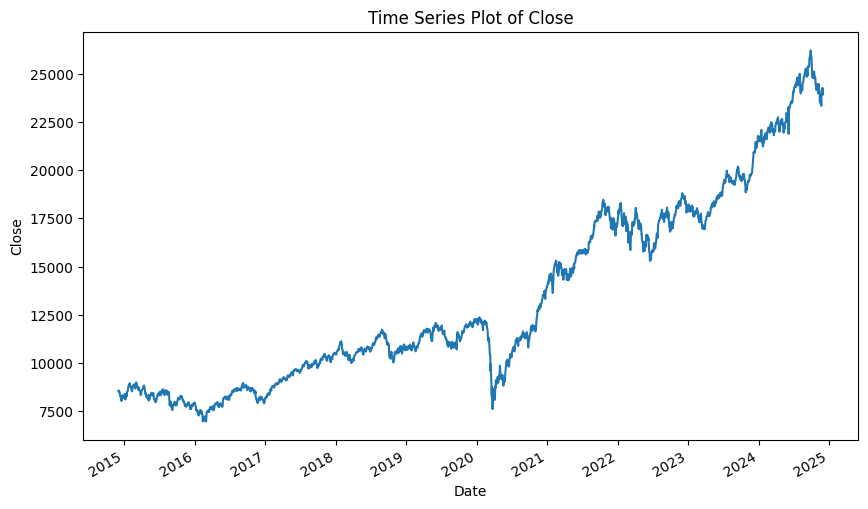

In [ ]:
df['Close'].plot(figsize=(10, 6))
plt.title('Time Series Plot of Close')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print(f"ADF p-value: {result[1]}")

# If p-value > 0.05, data is non-stationary and needs differencing



ADF p-value: 0.9904566986894129


In [ ]:
df['Differenced_Close'] = df['Close'].diff().dropna()

# Re-check stationarity on the differenced series
result_diff = adfuller(df['Differenced_Close'].dropna())
print(f"ADF p-value after differencing: {result_diff[1]}")



ADF p-value after differencing: 0.0


In [ ]:
df["Differenced_Close"]

,Differenced_Close
Date,
2014-12-01,NaN
2014-12-02,-31.200195
2014-12-03,12.950195
2014-12-04,26.750000
2014-12-05,-26.100586
...,...
2024-11-25,314.650391
2024-11-26,-27.400391
2024-11-27,80.400391


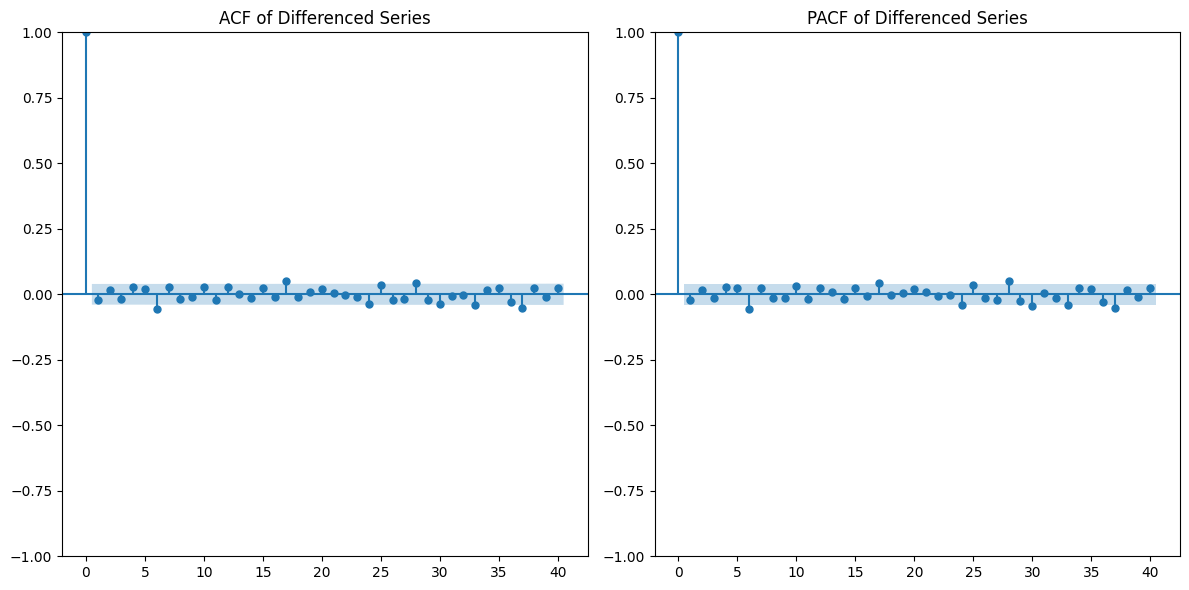

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Create subplots
plt.figure(figsize=(12, 6))

# Plot ACF in the first subplot (1 row, 2 columns, 1st subplot)
plt.subplot(1, 2, 1)
plot_acf(df['Differenced_Close'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF of Differenced Series')

# Plot PACF in the second subplot (1 row, 2 columns, 2nd subplot)
plt.subplot(1, 2, 2)
plot_pacf(df['Differenced_Close'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF of Differenced Series')

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()





In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build the SARIMA model with the identified parameters
sarima_model = SARIMAX(df['Close'],
                       order=(1, 1, 1),    # Non-seasonal (p, d, q)
                       seasonal_order=(0, 0, 0, 0),  # Seasonal (P, D, Q, s)
                       enforce_stationarity=False,   # Allow non-stationary model
                       enforce_invertibility=False)  # Allow non-invertible model

# Fit the SARIMA model
sarima_fitted = sarima_model.fit(disp=False)

# Summary of the fitted model
print(sarima_fitted.summary())



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2460
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -15541.635
Date:                Wed, 05 Feb 2025   AIC                          31089.271
Time:                        04:44:22   BIC                          31106.691
Sample:                             0   HQIC                         31095.601
                               - 2460                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4994      0.298     -1.675      0.094      -1.084       0.085
ma.L1          0.4747      0.303      1.569      0.117      -0.118       1.068
sigma2      1.828e+04    248.309     73.623      0.0

In [ ]:
# Forecasting for the next 10 steps
forecast_steps = 10
forecast_values = sarima_fitted.forecast(steps=forecast_steps)

# Prepare forecasted dates for visualization
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Create a DataFrame with forecasted values and dates
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close': forecast_values
})

# Display the forecasted values with dates
print(forecast_df)




           Date  Forecasted_Close
2460 2024-11-30      24121.002561
2461 2024-12-01      24126.044946
2462 2024-12-02      24123.526819
2463 2024-12-03      24124.784352
2464 2024-12-04      24124.156350
2465 2024-12-05      24124.469969
2466 2024-12-06      24124.313350
2467 2024-12-07      24124.391564
2468 2024-12-08      24124.352505
2469 2024-12-09      24124.372011


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


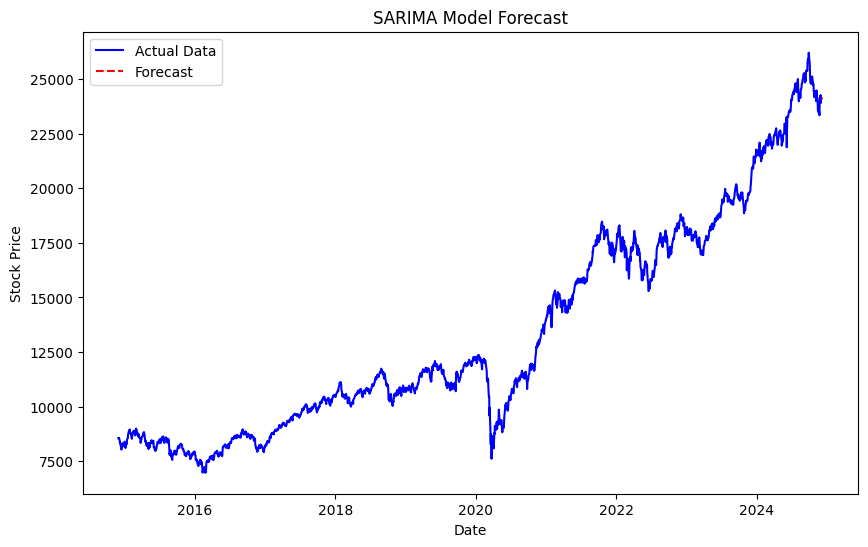

In [ ]:
# Visualize the forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Actual Data', color='blue')
plt.plot(forecast_dates, forecast_values, label='Forecast', color='red', linestyle='--')
plt.legend(loc='best')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Actual values (use the last portion of the data for validation)
actual_values = df['Close'].iloc[-forecast_steps:]

# Forecast values (the SARIMA forecast)
forecast_values = sarima_fitted.forecast(steps=forecast_steps)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))

# Calculate MAE
mae = mean_absolute_error(actual_values, forecast_values)

# Print the evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 435.0707940636513
MAE: 339.2420247595339


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMA model with train and test data

ADF Statistic: 1.313659488482476
p-value: 0.9966843318712351
The series is non-stationary. Differencing is needed.
ADF Statistic: -12.087101839425113
p-value: 2.1648539247352614e-22
The series is stationary.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 3388
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 4)   Log Likelihood              -20249.046
Date:                           Thu, 03 Apr 2025   AIC                          40510.093
Time:                                   04:17:11   BIC                          40546.852
Sample:                                        0   HQIC                         40523.234
                                          - 3388                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0087      0.010      0.908      0.364      -0.010       0.028
ar.L2          0.0038      0.008      0.458

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


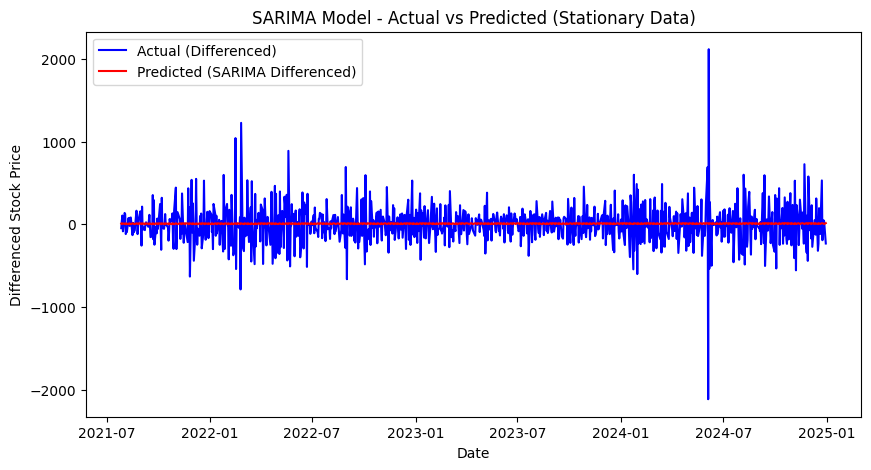

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# Load dataset
data_path = os.path.join("..", "data", "nifty50_10years.csv")
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Use only the 'Close' price for SARIMA
close_prices = df['Close']

# Check stationarity using Augmented Dickey-Fuller (ADF) Test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary. Differencing is needed.")

adf_test(close_prices)

# Make the series stationary (1st order differencing)
close_prices_diff = close_prices.diff().dropna()
adf_test(close_prices_diff)

# Train-test split
train_size = int(len(close_prices_diff) * 0.8)
train, test = close_prices_diff[:train_size], close_prices_diff[train_size:]

# Ensure test data is stationary
test = test.diff().dropna()

# Fit SARIMA model on differenced data
sarima_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,1,4))  # (p,d,q) and (P,D,Q,s) values can be tuned
sarima_model_fit = sarima_model.fit()

# Print model summary
print(sarima_model_fit.summary())

# Predict on test set using stationary data
predictions_diff = sarima_model_fit.forecast(steps=len(test))

# Evaluate SARIMA model
mae_sarima = mean_absolute_error(test, predictions_diff)
rmse_sarima = np.sqrt(mean_squared_error(test, predictions_diff))
print(f"SARIMA MAE: {mae_sarima}, SARIMA RMSE: {rmse_sarima}")

# Plot SARIMA predictions
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label="Actual (Differenced)", color='blue')
plt.plot(test.index, predictions_diff, label="Predicted (SARIMA Differenced)", color='red')
plt.title("SARIMA Model - Actual vs Predicted (Stationary Data)")
plt.xlabel("Date")
plt.ylabel("Differenced Stock Price")
plt.legend()
plt.show()